<center><font color='steelblue'> <font size = "5,5">CORPORACIÓN UNIVERSITARIA MINUTO DE DIOS </font></center><br>
<center><font color='steelblue'> <font size = "5">FACULTAD DE INGENIERÍA</font></center><br>
<center><font color='steelblue'> <font size = "4">PROGRAMA INGENIERÍA DE SISTEMAS</font></center><br>
<center><font color='steelblue'> <font size = "3">CURSO BASES DE DATOS MASIVAS</font></center><br>
<center><font color="yellow" size = "4" face = "small fonts">Proyecto Modular - Mojo</font></center>

<center><font color="olive" size = "4" face = "small fonts">DATOS DE LOS PARTICIPANTES DEL GRUPO</font></center>

<font color="yellow" size = "4" face = "small fonts">NRC: </font></center><br>
<font color="yellow" size = "4" face = "small fonts">Nombres: </font></center><br>
<font color="yellow" size = "4" face = "small fonts">ID:</font></center><br>

<font color="yellow" size = "4" face = "small fonts">El taller retoma algunas de las instrucciones utilizadas a través del curso de Bases de Datos Masivas, tener en cuenta seguir los pasos requeridos.</font></center><br>

<font color="yellow" size = "4" face = "small fonts">Al Cargar los archivos dispuestos en la carpeta Poryecto final BDM se debe utilizar sentencias que no fijen el path, este debe se dinámico en caso de que se creen nuevos paquetes</font></center><br>

<font color="red" size = "4" face = "small fonts">El ejercicio consta de seguir el cuaderno y  realizar las tareas solicitadas, Utilizar y citar la documentación propia de cada una de las herramientas utilizadas para realizar el tratamiento a la data.</font></center><br>

<font color="yellow" size = "4" face = "small fonts">1. Configuración e importe de las librerias.</font></center><br>

In [1]:
# Esta extencion permite que jupyter detecte cambios externos y recargue sin tener que reiniciar VSC
%load_ext autoreload
%autoreload 2

In [23]:
# Importar la librearia os para poder interactuar el sistema donde se esta ejecutando los archivos
import os
import requests
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import json

<font color="yellow" size = "4" face = "small fonts">2. Configure y levante los contenedores necesarios para la actividad, recuerde que la arquitectura respeta a 3 contenedores con una distribucion de DBMongo en cada una de ellas, un contenedor que tiene configurado Mojolicious con todas sus dependencias junto con una base de datos Relacional la cual sera escogida a su gusto.</font></center><br>

In [ ]:
# Moverse a la carpeta data donde estan los archivos para lanzar el docker
os.chdir("../data")
# Crear y ejecutar el docker-compose.yml
os.system("docker-compose up --build")

<font color="yellow" size = "4" face = "small fonts">3. Una vez tenga el contenedor arriba cargue los datos .Json, uno por cada contenedor DBMongo.</font></center><br>

<font color="yellow" size = "4" face = "small fonts">Tenga en cuenta que debe tener la replica de los formatos `JSon` en cada contenedor</font></center><br>

In [92]:
# Con estos comandos se deben cargar los datos .json dentro de las mongoDB sin necesidad de una funcion.

# Comando para importar personas.json
os.system("docker cp ../data/personas.json core_container:/app/data/personas.json")

# Comando para importar articulos.json
os.system("docker cp ../data/articulos.json core_container:/app/data/articulos.json")

# Comando para importar ventas.json
os.system("docker cp ../data/ventas.json core_container:/app/data/ventas.json") 

0

<font color="yellow" size = "4" face = "small fonts">Se debe colocar el puerto expuesto del contenedor `Mojo`, para llamar la función y cargar los datos</font></center><br>

In [93]:
# Cargar data a las Mongo a con la funcion
requests.get("http://localhost:8080/load_data")

<Response [200]>

<font color="yellow" size = "4" face = "small fonts">4. Muestre los datos que fueron almacenados en cada una de las distribuciones de BDMongo.</font></center><br>

In [ ]:
# Verificar conteo de documentos en la colección personas
os.system("")

# Verificar conteo de documentos en la colección articulos
os.system("")

# Verificar conteo de documentos en la colección ventas
os.system("")

<font color="yellow" size = "4" face = "small fonts">Consultar a tráves del puerto expuesto la data que se encuentran en las colecciones personas, articulos y ventas de DBMongo</font></center><br>

In [ ]:
# Ver personas en MongoDB
personas = requests.get("http://localhost:8080/mongo/personas")
print(json.dumps(personas.json(), ensure_ascii=False, indent=2))

In [ ]:
# Ver articulos en MongoDB
articulos = requests.get("http://localhost:8080/mongo/articulos")
print(json.dumps(articulos.json(), ensure_ascii=False, indent=2))

In [ ]:
# Ver ventas en MongoDB
ventas = requests.get("http://localhost:8080/mongo/ventas")
print(json.dumps(ventas.json(), ensure_ascii=False, indent=2))

<font color="yellow" size = "4" face = "small fonts">5. Verifique la estructura y tipo de los datos almacenados en las distribuciones DBMongo, genere una ETL para almacenar cada una de las distribuciones en la base de datos Relacional que configuro con anterioridad, recuerde que cada distribucion debe ir en una tabla relacional respetando la integridad referencial.</font></center><br>

In [94]:
# Funciones en Python para obtener datos de MongoDB para articulos
def limpiar_valor_numerico(valor):
    
    if valor is None:
        return None
    
    # Convertir a string y limpiar espacios
    valor_str = str(valor).strip()
    
    # Eliminar caracteres no numéricos (excepto el signo negativo al inicio)
    valor_limpio = re.sub(r'[^\d-]', '', valor_str)
    
    try:
        return int(valor_limpio)
    except (ValueError, TypeError):
        return None
    


# Función para verificar y limpiar idArticulo y cantidadArticulo donde debe ser un dato entero, tener en cuenta elimiar el id que proporciona 
# DBMongo a cada uno de las colecciones para cargarla a la Bases de Datos Relacional en SQLlite que importo.
def filtrar_y_limpiar_articulos(datos):
    # Definir los campos que necesitan ser numéricos
    campos_a_limpiar = ['idArticulo', 'cantidadArticulo']
    datos_limpios = []
    
    # Primera fase: Limpiar datos
    for documento in datos:
        # Eliminar el _id de MongoDB
        if '_id' in documento:
            del documento['_id']
        
        campos_validos = True
        
        # Validar y limpiar campos numéricos
        for campo in campos_a_limpiar:
            valor_limpio = limpiar_valor_numerico(documento.get(campo))
            
            if valor_limpio is None:
                campos_validos = False
                break
            
            documento[campo] = valor_limpio
        
        # Limpiar precioArticulo (puede ser float)
        if 'precioArticulo' in documento:
            try:
                precio_str = str(documento['precioArticulo']).strip()
                documento['precioArticulo'] = float(re.sub(r'[^\d.-]', '', precio_str))
            except (ValueError, TypeError):
                campos_validos = False
        
        if campos_validos:
            datos_limpios.append(documento)
    
    # Segunda fase: Consolidar artículos duplicados
    articulos_dict = {}
    
    for articulo in datos_limpios:
        id_articulo = articulo['idArticulo']
        
        if id_articulo not in articulos_dict:
            # Primer registro de este artículo
            articulos_dict[id_articulo] = {
                'idArticulo': id_articulo,
                'nombreArticulo': articulo.get('nombreArticulo', ''),
                'cantidadArticulo': articulo['cantidadArticulo'],
                'precioArticulo': articulo.get('precioArticulo', 0),
                'suma_precios': articulo.get('precioArticulo', 0),
                'contador': 1
            }
        else:
            # Artículo duplicado: sumar cantidad y precios
            articulos_dict[id_articulo]['cantidadArticulo'] += articulo['cantidadArticulo']
            articulos_dict[id_articulo]['suma_precios'] += articulo.get('precioArticulo', 0)
            articulos_dict[id_articulo]['contador'] += 1
    
    # Tercera fase: Calcular promedio de precios
    articulos_consolidados = []
    for articulo in articulos_dict.values():
        articulo['precioArticulo'] = round(articulo['suma_precios'] / articulo['contador'], 2)
        # Eliminar campos auxiliares
        del articulo['suma_precios']
        del articulo['contador']
        articulos_consolidados.append(articulo)
    
    return articulos_consolidados


# Uso de la función
response = requests.get("http://localhost:8080/mongo/articulos")
articulos = response.json()
articulos_limpios = filtrar_y_limpiar_articulos(articulos)
print(json.dumps(articulos_limpios, ensure_ascii=False, indent=2))

# Insertar en SQLite
for articulo in articulos_limpios:
    try:
        response = requests.post("http://localhost:8080/sqlite/articulos", json=articulo)
        if response.status_code != 200:
            print(f"Error al insertar artículo {articulo.get('idArticulo')}: {response.json()}")
    except Exception as e:
        print(f"Excepción al insertar artículo: {e}")

[
  {
    "idArticulo": 358,
    "nombreArticulo": "Intel i9",
    "cantidadArticulo": 5696,
    "precioArticulo": 305.78
  },
  {
    "idArticulo": 267,
    "nombreArticulo": "Kingston HyperX Cloud II",
    "cantidadArticulo": 9319,
    "precioArticulo": 309.26
  },
  {
    "idArticulo": 474,
    "nombreArticulo": "SeaSonic Focus Plus",
    "cantidadArticulo": 9613,
    "precioArticulo": 248.25
  },
  {
    "idArticulo": 791,
    "nombreArticulo": "Fractal Design Meshify",
    "cantidadArticulo": 10751,
    "precioArticulo": 292.39
  },
  {
    "idArticulo": 70,
    "nombreArticulo": "Bose QuietComfort Headphones",
    "cantidadArticulo": 11836,
    "precioArticulo": 148.29
  },
  {
    "idArticulo": 1834,
    "nombreArticulo": "Sony PlayStation 5",
    "cantidadArticulo": 462,
    "precioArticulo": 331.76
  },
  {
    "idArticulo": 238,
    "nombreArticulo": "Razer BlackWidow Keyboard",
    "cantidadArticulo": 15042,
    "precioArticulo": 229.66
  },
  {
    "idArticulo": 50,
    "no

In [ ]:
# Obtener datos de MongoDB para personas, escriba un ETL donde haga la validación de numeroDocumento y telefono, asegurando que solo contengan valores 
# numéricos, tener en cuenta elimiar el id que proporciona DBMongo a cada uno de las colecciones para cargarla a la Bases de Datos Relacional en SQLlite que importo.

def filtrar_limpiar_personas(datos):
    datos_limpios = []
    campos_a_limpiar = ['telefono']
    
    # Primera fase: Limpiar datos
    for documento in datos:
        # Eliminar el _id de MongoDB
        if '_id' in documento:
            del documento['_id']
        
        campos_validos = True
        
        for campo in campos_a_limpiar:
            valor_limpio = limpiar_valor_numerico(documento.get(campo))
            
            if valor_limpio is None:
                campos_validos = False
                break

            documento[campo] = str(valor_limpio)
        
        if campos_validos:
            datos_limpios.append(documento)
    
    return datos_limpios

response = requests.get("http://localhost:8080/mongo/personas")
personas = response.json()
personas_limpias = filtrar_limpiar_personas(personas)

# Encontrar documentos repetidos
documentos_repetidos = {}
for persona in personas_limpias:
    num_doc = persona.get('numeroDocumento')
    if num_doc:
        if num_doc in documentos_repetidos:
            documentos_repetidos[num_doc].append(persona)
        else:
            documentos_repetidos[num_doc] = [persona]

# Filtrar solo los que tienen duplicados
duplicados = {doc: personas for doc, personas in documentos_repetidos.items() if len(personas) > 1}

# Imprimir los duplicados
if duplicados:
    print(f"Se encontraron {len(duplicados)} números de documento repetidos:\n")
    for num_doc, personas_duplicadas in duplicados.items():
        print(f"Número de documento: {num_doc} (aparece {len(personas_duplicadas)} veces)")
        for i, persona in enumerate(personas_duplicadas, 1):
            print(f"  {i}. NumeroDocumento: {persona.get('numeroDocumento')} - Nombres: {persona.get('nombres')} - Apellidos: {persona.get('primerApellido')} {persona.get('segundoApellido')} - Teléfono: {persona.get('telefono')}")
        print()
else:
    print("No se encontraron números de documento repetidos.")
# Insertar en SQLite
for persona in personas_limpias:
    try:
        response = requests.post("http://localhost:8080/sqlite/personas", json=persona)
        if response.status_code != 200:
            print(f"Error al insertar persona {persona.get('idPersona')}: {response.json()}")
    except Exception as e:
        print(f"Excepción al insertar persona: {e}")
# print(json.dumps(personas_limpias, ensure_ascii=False, indent=2))

In [ ]:
# Obtener datos de MongoDB para ventas, escriba un ETL donde haga la validación de idComprador, idArticulo y cantidadProductos asegurando que solo contengan valores 
# numéricos, tener en cuenta elimiar el id que proporciona DBMongo a cada uno de las colecciones para cargarla a la Bases de Datos Relacional en SQLlite que importo.


# Obtener datos de MongoDB para ventas
response = requests.get("http://localhost:8080/mongo/ventas")
ventas = response.json()
ventas_limpias = filtrar_y_limpiar(ventas, 'idVenta', 'idComprador', 'idArticulo', 'cantidadProductos')
print(json.dumps(ventas_limpias, ensure_ascii=False, indent=2))

<font color="yellow" size = "4" face = "small fonts">6. Muestre la data almacenada en la base de datos Relacional que esta usando, tabla por tabla.</font></center><br>

In [6]:
# Mostrar data almacenada en la tabla personas
# Conectar a la base de datos SQLite
conexion = sqlite3.connect('../data/data/almacen.sqlite')

# Crear una consulta SQL y cargar los resultados en un DataFrame
consulta = "SELECT * FROM personas;"

df = pd.read_sql_query(consulta, conexion)

# Mostrar los datos
print(df)

# Cerrar la conexión
conexion.close()


   numeroDocumento nombres primerApellido segundoApellido fechaNacimiento  \
0         11223344  Carlos      Rodríguez            None      1995-03-10   
1         12345678    Juan          Pérez        González      1990-05-15   
2         87654321   María          López        Martínez      1985-08-20   

     telefono          direccion             email  
0  3207654321  Avenida 78 #90-12  carlos@email.com  
1  3001234567   Calle 123 #45-67    juan@email.com  
2  3109876543  Carrera 45 #12-34   maria@email.com  


In [20]:
# Mostrar data almacenada en la tabla articulos
# Conectar a la base de datos SQLite
conexion = sqlite3.connect('../data/data/almacen.sqlite')

# Crear una consulta SQL y cargar los resultados en un DataFrame
consulta = "SELECT * FROM articulos"
df = pd.read_sql_query(consulta, conexion)

# Mostrar los datos
print(df)

# Cerrar la conexión
conexion.close()

    idArticulo      nombreArticulo  precioArticulo  cantidadArticulo
0            1              Laptop         1200.50                10
1            2               Mouse           25.99                50
2            3             Teclado           45.00                30
3            4             Monitor          350.00                15
4            5              Webcam           89.99                25
5            6         Auriculares           65.50                40
6            7           Micrófono          120.00                20
7            8           Impresora          450.00                 8
8            9             Scanner          280.00                12
9           10              Tablet          599.99                18
10          11          Smartphone          899.00                22
11          12            Cargador           35.00                60
12          13           Cable USB           15.50               100
13          14  Disco Duro Externo

In [19]:
# Mostrar data almacenada en la tabla ventas
# Conectar a la base de datos SQLite
conexion = sqlite3.connect('../data/data/almacen.sqlite')

# Crear una consulta SQL y cargar los resultados en un DataFrame
consulta = "SELECT * FROM ventas;"
df = pd.read_sql_query(consulta, conexion)

# Mostrar los datos
print(df)

# Cerrar la conexión
conexion.close()

    idVenta  idComprador  idArticulo  cantidadProductos  precioTotal
0         1     12345678           1                  1      1200.50
1         2     87654321           2                  2        51.98
2         3     11223344           3                  1        45.00
3         4     22334455           4                  2       700.00
4         5     33445566           5                  1        89.99
5         6     44556677           6                  3       196.50
6         7     55667788           7                  1       120.00
7         8     66778899           8                  1       450.00
8         9     77889900           9                  2       560.00
9        10     88990011          10                  1       599.99
10       11     99001122          11                  1       899.00
11       12     10111213          12                  4       140.00
12       13     20212223          13                  5        77.50
13       14     30313233          

<font color="yellow" size = "4" face = "small fonts">7. Grafique los 5 articulos mas vendidos.</font></center><br>

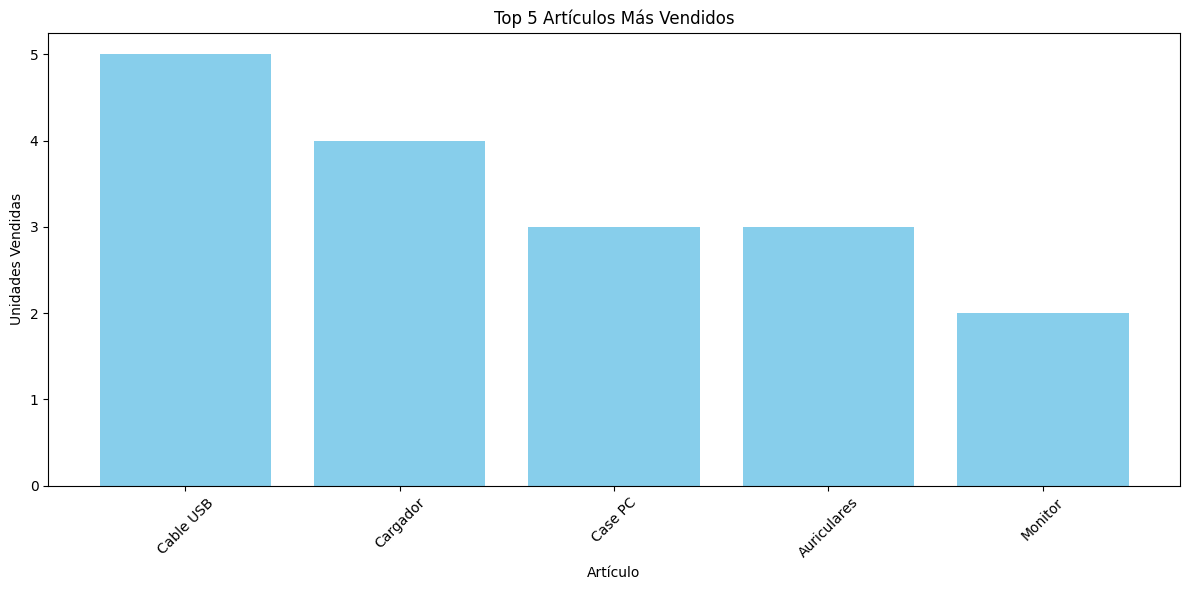

In [18]:
# Conectar a la base de datos
conexion = sqlite3.connect('../data/data/almacen.sqlite') 

  # Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """SELECT
    a.idArticulo,
    a.nombreArticulo,
    SUM(v.cantidadProductos) AS unidades_vendidas,
    SUM(v.precioTotal)      AS ingresos_totales
    FROM ventas v
    JOIN articulos a ON a.idArticulo = v.idArticulo
    GROUP BY a.idArticulo, a.nombreArticulo
    ORDER BY unidades_vendidas DESC, ingresos_totales DESC, a.nombreArticulo ASC
    LIMIT 5;"""


df = pd.read_sql_query(consulta, conexion)

# Cerrar la conexión
conexion.close()

# Graficar los datos
plt.figure(figsize=(12, 6))
plt.bar(df['nombreArticulo'], df['unidades_vendidas'], color='skyblue')
plt.title('Top 5 Artículos Más Vendidos')
plt.xlabel('Artículo')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()



<font color="yellow" size = "4" face = "small fonts">8. Grafique los 5 compradores que han realizado más compras.</font></center><br>

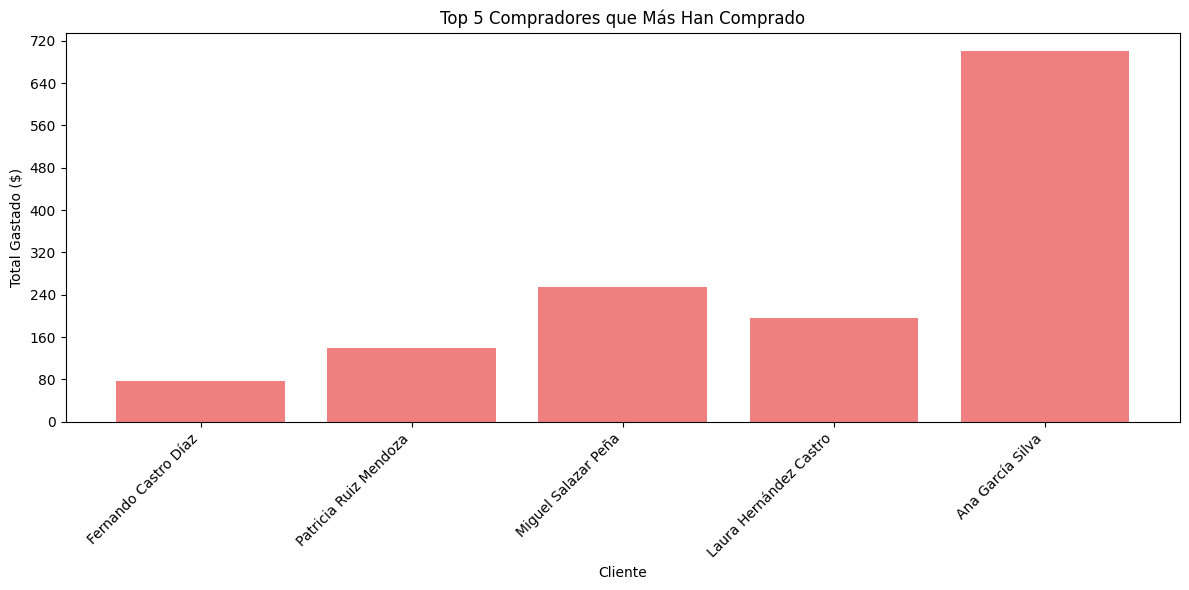

In [25]:
# Conectar a la base de datos
conexion = sqlite3.connect('../data/data/almacen.sqlite') 

# Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """
SELECT
  p.numeroDocumento,
  p.nombres,
  p.primerApellido,
  p.segundoApellido,
  COUNT(*)                           AS compras_realizadas,
  SUM(v.cantidadProductos)           AS unidades_compradas,
  SUM(v.precioTotal)                 AS total_gastado
FROM ventas v
JOIN personas p ON p.numeroDocumento = v.idComprador
GROUP BY p.numeroDocumento, p.nombres, p.primerApellido, p.segundoApellido
ORDER BY unidades_compradas DESC, total_gastado DESC, p.primerApellido ASC, p.nombres ASC
LIMIT 5;
"""
df = pd.read_sql_query(consulta, conexion)


# Asegura tipos y arma el nombre completo de forma segura
# Crear nombre completo del cliente
df['cliente'] = (df['nombres'] + ' ' + df['primerApellido'] + ' ' + df['segundoApellido']).str.strip()

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(df['cliente'], df['total_gastado'], color='lightcoral')
plt.title('Top 5 Compradores que Más Han Comprado')
plt.xlabel('Cliente')
plt.ylabel('Total Gastado ($)')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# Cerrar la conexión
conexion.close()


<font color="yellow" size = "4" face = "small fonts">9. Grafique la distribución de precios de los 5 primeros artículos .</font></center><br>

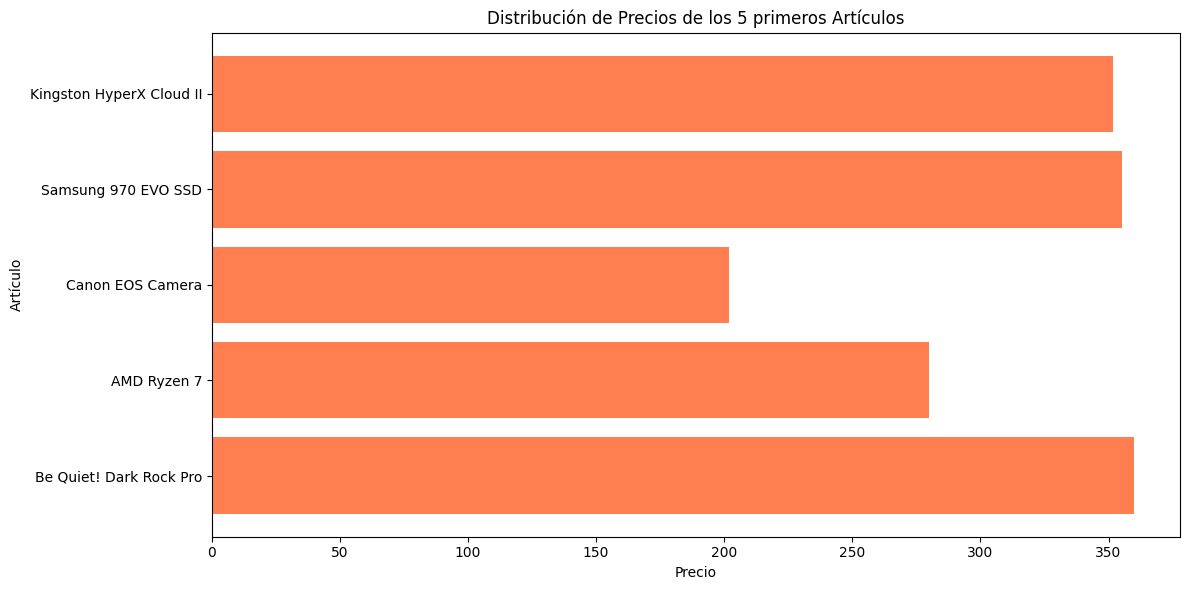

In [ ]:
# Conectar a la base de datos
conexion = sqlite3.connect('') 

# Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """

"""
df = pd.read_sql_query(consulta, conexion)

# Graficar



<font color="yellow" size = "4" face = "small fonts">10. Grafique los 5 artículos que menos se han vendido.</font></center><br>

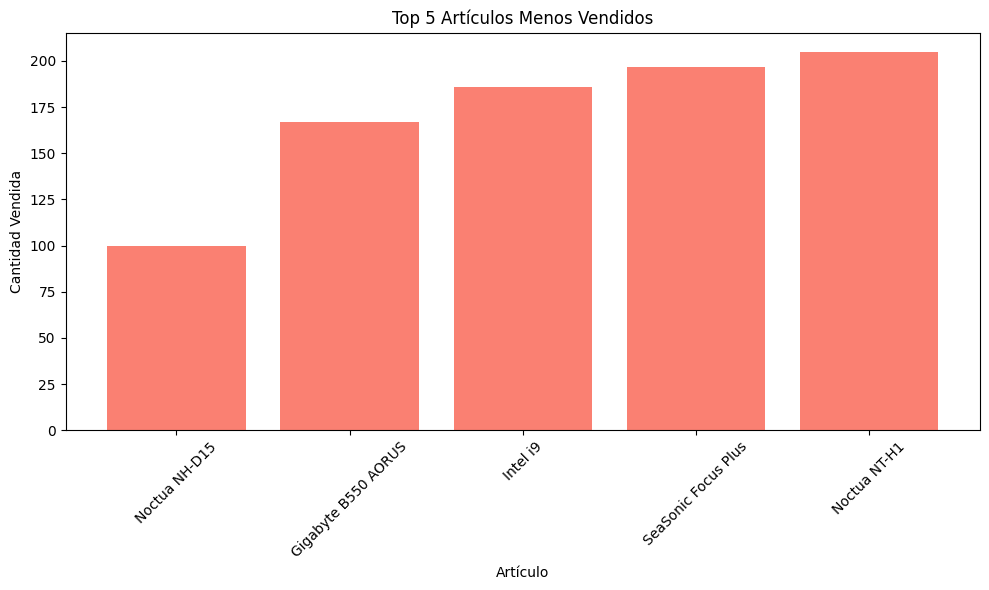

In [ ]:
# Conectar a la base de datos
conexion = sqlite3.connect('') 

# Ejecutar la consulta y cargar los datos en un DataFrame
consulta = """

"""
df = pd.read_sql_query(consulta, conexion)

# Cerrar la conexión
conexion.close()

# Graficar los datos
